<a href="https://colab.research.google.com/github/DaniChinwendu/skin-sensitization-prediction/blob/main/APPLICABIBILITY_DOMAIN_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_test.csv to df_test.csv
Saving df_train.csv to df_train.csv



Similarity-Based Applicability Domain (AD) Assessment

This module implements a similarity-based AD methodology for molecular fingerprints
using Tanimoto similarity. The threshold is calculated as:

    S_T = γ̄ + Zσ

where:
    - γ̄ (gamma_bar): average Tanimoto similarity between training compounds
    - σ (sigma): standard deviation of the Tanimoto similarities
    - Z: predefined significance level (e.g., 0.5 for liberal, 1.0 for moderate)

A test compound is considered within the AD if its average similarity to its
k most similar training compounds exceeds the threshold S_T.

Author: Adapted for computational toxicology applications


In [ ]:
!pip install rdkit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 43.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit import RDLogger
from rdkit.Avalon import pyAvalonTools
import warnings

RDLogger.DisableLog('rdApp.*')
print("Libraries loaded!")

Libraries loaded!


In [ ]:
class SimilarityBasedAD:
    """
    Similarity-based Applicability Domain assessment.

    Parameters:
    - z_score: Z value for threshold (0.5=liberal, 1.0=moderate, 1.5=conservative)
    - k_neighbors: number of nearest neighbors to consider
    - fingerprint_type: 'morgan', 'rdkit', 'maccs', or 'avalon'
    - fp_radius: radius for Morgan fingerprints
    - fp_bits: number of bits for fingerprints
    """

    def __init__(self, z_score=0.5, k_neighbors=5, fingerprint_type='morgan',
                 fp_radius=2, fp_bits=2048):
        self.z_score = z_score
        self.k_neighbors = k_neighbors
        self.fingerprint_type = fingerprint_type.lower()
        self.fp_radius = fp_radius
        self.fp_bits = fp_bits
        self.threshold_ = None
        self.gamma_bar_ = None
        self.sigma_ = None
        self.training_fps_ = None

    def _smiles_to_fp(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        if self.fingerprint_type == 'morgan':
            return AllChem.GetMorganFingerprintAsBitVect(mol, self.fp_radius, nBits=self.fp_bits)
        elif self.fingerprint_type == 'rdkit':
            return Chem.RDKFingerprint(mol, fpSize=self.fp_bits)
        elif self.fingerprint_type == 'maccs':
            return AllChem.GetMACCSKeysFingerprint(mol)
        elif self.fingerprint_type == 'avalon':
            return pyAvalonTools.GetAvalonFP(mol, nBits=self.fp_bits)

    def fit(self, train_smiles, verbose=True):
        """Fit AD on training compounds."""
        self.training_fps_ = []
        invalid = 0

        for smi in train_smiles:
            fp = self._smiles_to_fp(smi)
            if fp is not None:
                self.training_fps_.append(fp)
            else:
                invalid += 1

        if invalid > 0:
            print(f"Warning: {invalid} invalid SMILES skipped")

        n = len(self.training_fps_)
        if verbose:
            print(f"Computing pairwise similarities for {n} training compounds...")

        # Compute pairwise similarities
        similarities = []
        for i in range(n):
            for j in range(i+1, n):
                sim = DataStructs.TanimotoSimilarity(self.training_fps_[i], self.training_fps_[j])
                similarities.append(sim)

        self.gamma_bar_ = np.mean(similarities)
        self.sigma_ = np.std(similarities)
        self.threshold_ = self.gamma_bar_ + self.z_score * self.sigma_

        if verbose:
            print(f"\n--- AD Threshold Calculation ---")
            print(f"γ̄ (mean similarity): {self.gamma_bar_:.4f}")
            print(f"σ (std deviation):   {self.sigma_:.4f}")
            print(f"Z (significance):    {self.z_score}")
            print(f"S_T (threshold):     {self.threshold_:.4f}")

        return self

    def predict(self, test_smiles):
        """Predict AD membership for test compounds."""
        results = []

        for smi in test_smiles:
            fp = self._smiles_to_fp(smi)

            if fp is None:
                results.append({
                    'SMILES': smi,
                    'valid': False,
                    'avg_sim_to_k_neighbors': np.nan,
                    'max_similarity': np.nan,
                    'in_AD': False
                })
                continue

            # Compute similarity to all training compounds
            sims = [DataStructs.TanimotoSimilarity(fp, train_fp) for train_fp in self.training_fps_]
            sims = np.array(sims)

            # Get k most similar
            k = min(self.k_neighbors, len(sims))
            top_k = np.sort(sims)[-k:]
            avg_sim = np.mean(top_k)

            results.append({
                'SMILES': smi,
                'valid': True,
                'avg_sim_to_k_neighbors': avg_sim,
                'max_similarity': np.max(sims),
                'in_AD': avg_sim >= self.threshold_
            })

        return pd.DataFrame(results)

    def print_report(self, results_df, name="Test"):
        """Print coverage report."""
        valid = results_df[results_df['valid']]
        n_in_ad = valid['in_AD'].sum()
        n_valid = len(valid)
        coverage = n_in_ad / n_valid * 100 if n_valid > 0 else 0

        print(f"\n{'='*50}")
        print(f"AD Coverage Report - {name} Set")
        print(f"{'='*50}")
        print(f"Threshold (S_T):  {self.threshold_:.4f}")
        print(f"k neighbors:      {self.k_neighbors}")
        print(f"Total compounds:  {len(results_df)}")
        print(f"Valid SMILES:     {n_valid}")
        print(f"Within AD:        {n_in_ad} ({coverage:.1f}%)")
        print(f"Outside AD:       {n_valid - n_in_ad} ({100-coverage:.1f}%)")
        print(f"{'='*50}")

print("AD class defined!")

AD class defined!


In [ ]:
# ============================================
# OPTION A: Upload CSV files
# ============================================
# from google.colab import files
# uploaded = files.upload()

# ============================================
# OPTION B: Load from Google Drive
# ============================================
# from google.colab import drive
# drive.mount('/content/drive')

# ============================================
# OPTION C: Example data (default)
# ============================================
# Uncomment and modify the paths below for your data

USE_EXAMPLE_DATA = True  # Set to False to use your own data

if USE_EXAMPLE_DATA:
    # Example molecules
    train_smiles = [
        'CC(=O)Oc1ccccc1C(=O)O',      # Aspirin
        'CC(C)Cc1ccc(cc1)C(C)C(=O)O', # Ibuprofen
        'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', # Caffeine
        'CC(=O)Nc1ccc(O)cc1',          # Paracetamol
        'c1ccc2c(c1)cc3ccccc3n2',      # Acridine
        'c1ccc(cc1)c2ccccc2',          # Biphenyl
        'CCO',                          # Ethanol
        'c1ccccc1',                     # Benzene
    ]

    test_smiles = [
        'CC(=O)Nc1ccc(O)cc1',          # Paracetamol
        'c1ccc(cc1)O',                  # Phenol
        'CCCCCCCCCCCCCCCCCC',           # Long alkane
    ]
    print(f"Loaded {len(train_smiles)} training and {len(test_smiles)} test compounds")

else:


Loaded 8 training and 3 test compounds


In [ ]:
# Load your own data
train_df = pd.read_csv('/content/df_train.csv')  # <-- Change path
test_df = pd.read_csv('/content/df_test.csv')    # <-- Change path

train_smiles = train_df['smiles'].tolist()  # <-- Change column name if needed
test_smiles = test_df['smiles'].tolist()    # <-- Change column name if needed

print(f"Loaded {len(train_smiles)} training and {len(test_smiles)} test compounds")

Loaded 939 training and 235 test compounds


In [ ]:
# ============================================
# SET YOUR PARAMETERS HERE
# ============================================

Z_SCORE = 0.5              # 0.5=liberal, 1.0=moderate, 1.5=conservative
K_NEIGHBORS = 5            # Number of nearest neighbors
FINGERPRINT_TYPE = 'avalon' # 'morgan', 'rdkit', 'maccs', 'avalon'
FP_BITS = 2048             # Fingerprint size
FP_RADIUS = 2              # Only for Morgan fingerprints

print(f"Parameters set:")
print(f"  Z-score: {Z_SCORE}")
print(f"  k neighbors: {K_NEIGHBORS}")
print(f"  Fingerprint: {FINGERPRINT_TYPE}")

Parameters set:
  Z-score: 0.5
  k neighbors: 5
  Fingerprint: avalon


In [ ]:
# Initialize and fit the AD model
ad_model = SimilarityBasedAD(
    z_score=Z_SCORE,
    k_neighbors=K_NEIGHBORS,
    fingerprint_type=FINGERPRINT_TYPE,
    fp_radius=FP_RADIUS,
    fp_bits=FP_BITS
)

ad_model.fit(train_smiles, verbose=True)

Computing pairwise similarities for 939 training compounds...

--- AD Threshold Calculation ---
γ̄ (mean similarity): 0.1058
σ (std deviation):   0.0938
Z (significance):    0.5
S_T (threshold):     0.1527


In [ ]:
# Predict AD membership for test set
results = ad_model.predict(test_smiles)

# Print report
ad_model.print_report(results, "Test")

# Show results table
print("\nDetailed Results:")
results


AD Coverage Report - Test Set
Threshold (S_T):  0.1527
k neighbors:      5
Total compounds:  235
Valid SMILES:     235
Within AD:        235 (100.0%)
Outside AD:       0 (0.0%)

Detailed Results:


,SMILES,valid,avg_sim_to_k_neighbors,max_similarity,in_AD
0,C(=O)O,True,0.328571,0.500000,True
1,COC(=O)C(CCN1C=NC2=C1N=C(N=C2Cl)N)C(=O)OC,True,0.304319,0.312871,True
2,C1=CC(=CC=C1CCl)Cl,True,0.579565,0.655172,True
3,C1OC2=C(O1)C=C(C=C2)C=O,True,0.438540,0.504132,True
4,C1CCC(CC1)S,True,0.363031,0.535714,True
...,...,...,...,...,...
230,CCCCCCCCCC1=CC(=C(C=C1)O)C=NO,True,0.422241,0.436620,True
231,CC1CCCC(C1C(=O)OCC=C)(C)C,True,0.471076,0.547170,True
232,CC(C)C1CC(OC1=O)C(CC(CC2=CC(=C(C=C2)OC)OCCCOC)...,True,0.368999,0.400000,True
233,CC(C)(C1=CC(=C(C(=C1)Br)O)Br)C2=CC(=C(C(=C2)Br...,True,0.375920,0.447761,True


TSNE

Computing fingerprints...
Running t-SNE...


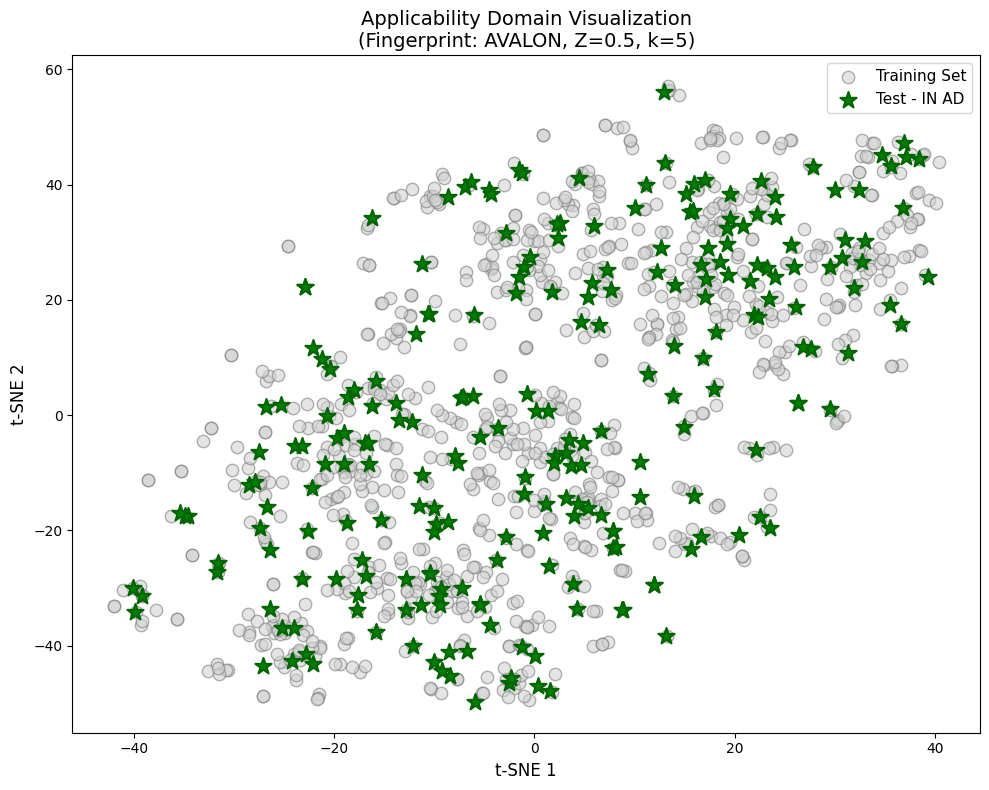


Plot saved as 'ad_tsne_plot.png'
Training compounds: 939
Test compounds IN AD: 235 (green stars)
Test compounds OUTSIDE AD: 0 (red X)


In [ ]:
# ============================================
# VISUALIZE AD WITH t-SNE
# ============================================

!pip install scikit-learn matplotlib seaborn -q

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Avalon import pyAvalonTools
import seaborn as sns

def smiles_to_fp_array(smiles_list, fp_type='avalon', fp_bits=2048, fp_radius=2):
    """Convert SMILES to numpy array of fingerprints."""
    fps = []
    valid_idx = []

    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue

        if fp_type == 'morgan':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, fp_radius, nBits=fp_bits)
        elif fp_type == 'avalon':
            fp = pyAvalonTools.GetAvalonFP(mol, nBits=fp_bits)
        elif fp_type == 'rdkit':
            fp = Chem.RDKFingerprint(mol, fpSize=fp_bits)
        elif fp_type == 'maccs':
            fp = AllChem.GetMACCSKeysFingerprint(mol)

        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)
        valid_idx.append(i)

    return np.array(fps), valid_idx

# Get fingerprint arrays for train and test
print("Computing fingerprints...")
train_fps, train_valid_idx = smiles_to_fp_array(train_smiles, fp_type=FINGERPRINT_TYPE)
test_fps, test_valid_idx = smiles_to_fp_array(test_smiles, fp_type=FINGERPRINT_TYPE)

# Combine for t-SNE
all_fps = np.vstack([train_fps, test_fps])
n_train = len(train_fps)
n_test = len(test_fps)

# Run t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_fps)-1))
coords = tsne.fit_transform(all_fps)

train_coords = coords[:n_train]
test_coords = coords[n_train:]

# Get AD status for test compounds
test_in_ad = results[results['valid']]['in_AD'].values

# ============================================
# PLOT
# ============================================
fig, ax = plt.subplots(figsize=(10, 8))

# Plot training set (gray)
ax.scatter(train_coords[:, 0], train_coords[:, 1],
           c='lightgray', s=80, alpha=0.6, label='Training Set', edgecolors='gray')

# Plot test set - IN AD (green)
test_in_mask = test_in_ad == True
if test_in_mask.sum() > 0:
    ax.scatter(test_coords[test_in_mask, 0], test_coords[test_in_mask, 1],
               c='green', s=150, marker='*', label='Test - IN AD', edgecolors='darkgreen', linewidths=1.5)

# Plot test set - OUTSIDE AD (red)
test_out_mask = test_in_ad == False
if test_out_mask.sum() > 0:
    ax.scatter(test_coords[test_out_mask, 0], test_coords[test_out_mask, 1],
               c='red', s=150, marker='X', label='Test - OUTSIDE AD', edgecolors='darkred', linewidths=1.5)

ax.set_xlabel('t-SNE 1', fontsize=12)
ax.set_ylabel('t-SNE 2', fontsize=12)
ax.set_title(f'Applicability Domain Visualization\n(Fingerprint: {FINGERPRINT_TYPE.upper()}, Z={Z_SCORE}, k={K_NEIGHBORS})', fontsize=14)
ax.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.savefig('ad_tsne_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'ad_tsne_plot.png'")
print(f"Training compounds: {n_train}")
print(f"Test compounds IN AD: {test_in_mask.sum()} (green stars)")
print(f"Test compounds OUTSIDE AD: {test_out_mask.sum()} (red X)")

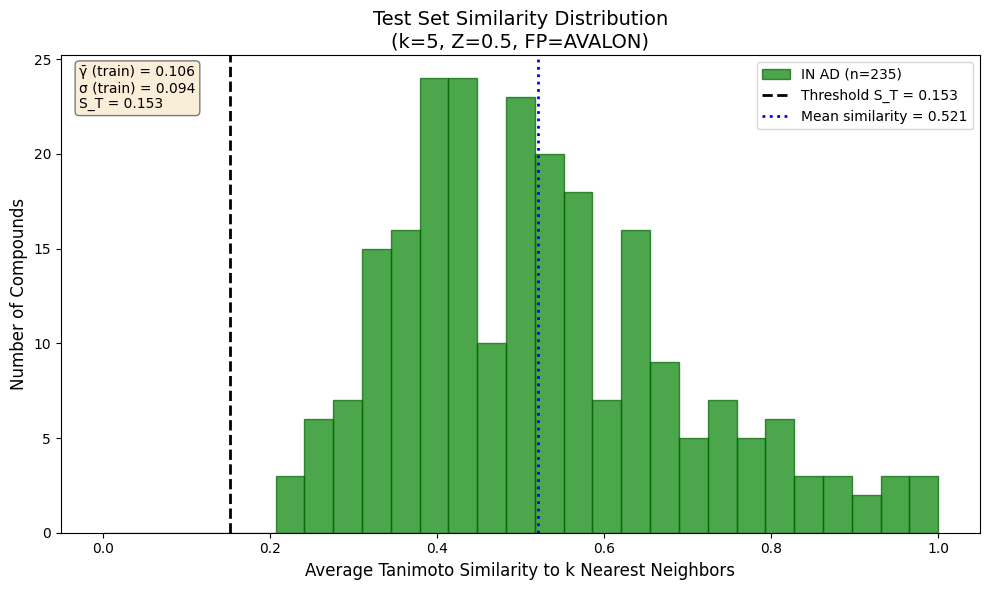


--- Summary Statistics ---
Threshold S_T: 0.1527
Test set mean similarity: 0.5210
Test set min similarity: 0.2099
Test set max similarity: 1.0000
Compounds IN AD: 235 (100.0%)
Compounds OUTSIDE AD: 0 (0.0%)


In [ ]:
# ============================================
# SIMILARITY DISTRIBUTION PLOT
# ============================================

import matplotlib.pyplot as plt
import numpy as np

# Get similarity values from results
valid_results = results[results['valid']]
similarities = valid_results['avg_sim_to_k_neighbors'].values
in_ad = valid_results['in_AD'].values

# Separate by AD status
sim_in_ad = similarities[in_ad]
sim_outside_ad = similarities[~in_ad]

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram
bins = np.linspace(0, 1, 30)

if len(sim_in_ad) > 0:
    ax.hist(sim_in_ad, bins=bins, alpha=0.7, color='green',
            label=f'IN AD (n={len(sim_in_ad)})', edgecolor='darkgreen')

if len(sim_outside_ad) > 0:
    ax.hist(sim_outside_ad, bins=bins, alpha=0.7, color='red',
            label=f'OUTSIDE AD (n={len(sim_outside_ad)})', edgecolor='darkred')

# Add threshold line
ax.axvline(x=ad_model.threshold_, color='black', linestyle='--', linewidth=2,
           label=f'Threshold S_T = {ad_model.threshold_:.3f}')

# Add mean similarity line
mean_sim = np.mean(similarities)
ax.axvline(x=mean_sim, color='blue', linestyle=':', linewidth=2,
           label=f'Mean similarity = {mean_sim:.3f}')

# Labels
ax.set_xlabel('Average Tanimoto Similarity to k Nearest Neighbors', fontsize=12)
ax.set_ylabel('Number of Compounds', fontsize=12)
ax.set_title(f'Test Set Similarity Distribution\n(k={ad_model.k_neighbors}, Z={ad_model.z_score}, FP={FINGERPRINT_TYPE.upper()})', fontsize=14)
ax.legend(loc='upper right', fontsize=10)

# Add text box with stats
stats_text = f'γ̄ (train) = {ad_model.gamma_bar_:.3f}\nσ (train) = {ad_model.sigma_:.3f}\nS_T = {ad_model.threshold_:.3f}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('similarity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n--- Summary Statistics ---")
print(f"Threshold S_T: {ad_model.threshold_:.4f}")
print(f"Test set mean similarity: {mean_sim:.4f}")
print(f"Test set min similarity: {similarities.min():.4f}")
print(f"Test set max similarity: {similarities.max():.4f}")
print(f"Compounds IN AD: {len(sim_in_ad)} ({len(sim_in_ad)/len(similarities)*100:.1f}%)")
print(f"Compounds OUTSIDE AD: {len(sim_outside_ad)} ({len(sim_outside_ad)/len(similarities)*100:.1f}%)")

In [ ]:
# Save to CSV
results.to_csv('ad_results.csv', index=False)
print("Results saved to ad_results.csv")

# Download the file (Colab)
# from google.colab import files
# files.download('ad_results.csv')

Results saved to ad_results.csv


In [ ]:
print("Effect of Z parameter on AD coverage:")
print("-" * 50)

for z in [0.0, 0.5, 1.0, 1.5]:
    ad_temp = SimilarityBasedAD(
        z_score=z,
        k_neighbors=K_NEIGHBORS,
        fingerprint_type=FINGERPRINT_TYPE
    )
    ad_temp.fit(train_smiles, verbose=False)
    res = ad_temp.predict(test_smiles)
    valid = res[res['valid']]
    coverage = valid['in_AD'].sum() / len(valid) * 100 if len(valid) > 0 else 0
    print(f"Z = {z:.1f}: Threshold = {ad_temp.threshold_:.4f}, Coverage = {coverage:.1f}%")

Effect of Z parameter on AD coverage:
--------------------------------------------------
Z = 0.0: Threshold = 0.1058, Coverage = 100.0%
Z = 0.5: Threshold = 0.1527, Coverage = 100.0%
Z = 1.0: Threshold = 0.1996, Coverage = 100.0%
Z = 1.5: Threshold = 0.2465, Coverage = 97.9%


In [ ]:
print("Comparison of fingerprint types:")
print("-" * 50)

for fp_type in ['morgan', 'avalon', 'rdkit', 'maccs']:
    ad_temp = SimilarityBasedAD(
        z_score=Z_SCORE,
        k_neighbors=K_NEIGHBORS,
        fingerprint_type=fp_type
    )
    ad_temp.fit(train_smiles, verbose=False)
    res = ad_temp.predict(test_smiles)
    valid = res[res['valid']]
    coverage = valid['in_AD'].sum() / len(valid) * 100 if len(valid) > 0 else 0
    print(f"{fp_type.upper():8s}: Threshold = {ad_temp.threshold_:.4f}, Coverage = {coverage:.1f}%")